## Imports

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix
from sklearn.preprocessing import LabelEncoder

## Data loading and preprocessing

In [7]:
train_data = pd.read_csv("AnimeDatasetNew.CSV")

In [9]:
train_data.columns

Index(['user_id', 'anime_id', 'name', 'genre', 'type', 'episodes', 'rating',
       'members', 'image_URL', 'user_preferences', 'browsing_history',
       'time_of_day', 'location', 'user_age', 'user_gender',
       'purchase_history', 'user_reviews'],
      dtype='object')

In [11]:
train_data.head(5)

,user_id,anime_id,name,genre,type,episodes,rating,members,image_URL,user_preferences,browsing_history,time_of_day,location,user_age,user_gender,purchase_history,user_reviews
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,96,https://haruhichan.com/wp-content/uploads/Pers...,3,9,Morning,USA,49,Female,3,8
1,214,3358,Kure-nai,"Comedy, Drama, Martial Arts",TV,12,7.52,59099,https://cdn.statically.io/img/nimegami.id/f=au...,5,2,Evening,UK,21,Male,5,5
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,"Comedy, Slice of Life",TV,12,4.92,5888,https://store.donanimhaber.com/36/59/7b/36597b...,4,1,Evening,Japan,59,Male,0,9
3,7,9239,Scoopers,"Action, Sci-Fi",OVA,1,6.08,195,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,1,3,Morning,Japan,27,Male,5,7
4,220,9204,Omae Umasou da na,"Action, Adventure, Fantasy, Kids",Movie,1,8.13,6645,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,4,0,Morning,Germany,34,Other,4,6


Taking only required columns to build, rating based recommendation, content based recommendation, collaborative filtering and seasonal recommendations.

In [13]:
train_data = train_data[[ 'user_id','anime_id','name','genre','type','episodes','rating','image_URL','time_of_day','purchase_history']]

In [16]:
train_data.head(5)

,user_id,anime_id,name,genre,type,episodes,rating,image_URL,time_of_day,purchase_history
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,https://haruhichan.com/wp-content/uploads/Pers...,Morning,3
1,214,3358,Kure-nai,"Comedy, Drama, Martial Arts",TV,12,7.52,https://cdn.statically.io/img/nimegami.id/f=au...,Evening,5
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,"Comedy, Slice of Life",TV,12,4.92,https://store.donanimhaber.com/36/59/7b/36597b...,Evening,0
3,7,9239,Scoopers,"Action, Sci-Fi",OVA,1,6.08,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,Morning,5
4,220,9204,Omae Umasou da na,"Action, Adventure, Fantasy, Kids",Movie,1,8.13,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,Morning,4


## Basic Operrations

In [18]:
train_data.shape

(1000, 10)

In [20]:
train_data.isnull().sum()

user_id              0
anime_id             0
name                 0
genre                5
type                 4
episodes             0
rating              25
image_URL            0
time_of_day          0
purchase_history     0
dtype: int64

In [22]:
train_data.dropna(subset=['genre', 'type'], inplace=True)

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\1572532000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.dropna(subset=['genre', 'type'], inplace=True)


In [24]:
train_data['rating'].fillna(0, inplace=True)

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\876495981.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['rating'].fillna(0, inplace=True)
C:\Users\himak\AppData\Local\Temp\ipykernel_20128\876495981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['rating'].fillna(0, inplace=True)


In [26]:
train_data.isnull().sum()

user_id             0
anime_id            0
name                0
genre               0
type                0
episodes            0
rating              0
image_URL           0
time_of_day         0
purchase_history    0
dtype: int64

### Check for duplicates

In [29]:
duplicated_rows=train_data.duplicated().sum()

In [31]:
print(duplicated_rows)

0


## Column renaming

In [33]:
train_data.columns

Index(['user_id', 'anime_id', 'name', 'genre', 'type', 'episodes', 'rating',
       'image_URL', 'time_of_day', 'purchase_history'],
      dtype='object')

In [35]:
column_name_mapping = {
     'user_id' : 'UserID',
    'anime_id' : 'AnimeID',                
    'name': 'Name',              
    'genre' : 'Genre',               
    'type' : 'Type',              
    'episodes' : 'EpisodeCount',                     
    'rating' : 'Rating',     
    'image_URL' : 'ImageURL'
}
train_data.rename(columns=column_name_mapping, inplace=True)

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\594093208.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.rename(columns=column_name_mapping, inplace=True)


In [37]:
train_data

,UserID,AnimeID,Name,Genre,Type,EpisodeCount,Rating,ImageURL,time_of_day,purchase_history
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,https://haruhichan.com/wp-content/uploads/Pers...,Morning,3
1,214,3358,Kure-nai,"Comedy, Drama, Martial Arts",TV,12,7.52,https://cdn.statically.io/img/nimegami.id/f=au...,Evening,5
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,"Comedy, Slice of Life",TV,12,4.92,https://store.donanimhaber.com/36/59/7b/36597b...,Evening,0
3,7,9239,Scoopers,"Action, Sci-Fi",OVA,1,6.08,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,Morning,5
4,220,9204,Omae Umasou da na,"Action, Adventure, Fantasy, Kids",Movie,1,8.13,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,Morning,4
...,...,...,...,...,...,...,...,...,...,...
995,499,10445,Perfect Day,Music,Music,1,7.59,https://vignette3.wikia.nocookie.net/tokyoghou...,Afternoon,4
996,74,1264,Yoroiden Samurai Troopers,"Adventure, Samurai, Sci-Fi, Shounen",TV,39,7.21,https://images-na.ssl-images-amazon.com/images...,Night,4
997,393,3439,Darcrows,Hentai,OVA,2,5.86,https://cdn.myanimelist.net/images/anime/6/589...,Morning,0
998,167,3518,Ginga no Uo Ursa Minor Blue,"Fantasy, Kids",OVA,1,6.33,https://cdn.myanimelist.net/images/anime/1226/...,Night,4


## Exploratory Data Analysis

In [40]:
num_animes = train_data['AnimeID'].nunique()
num_users = train_data['UserID'].nunique()
print(f"Number of unique Animes: {num_animes}")
print(f"Number of unique Users: {num_users}")

Number of unique Animes: 723
Number of unique Users: 440


In [42]:
anime_ratings = train_data.groupby('Genre')['Rating'].mean().reset_index()
anime_ratings = anime_ratings.sort_values(by='Rating', ascending=False)
top_genres = anime_ratings.head(5)

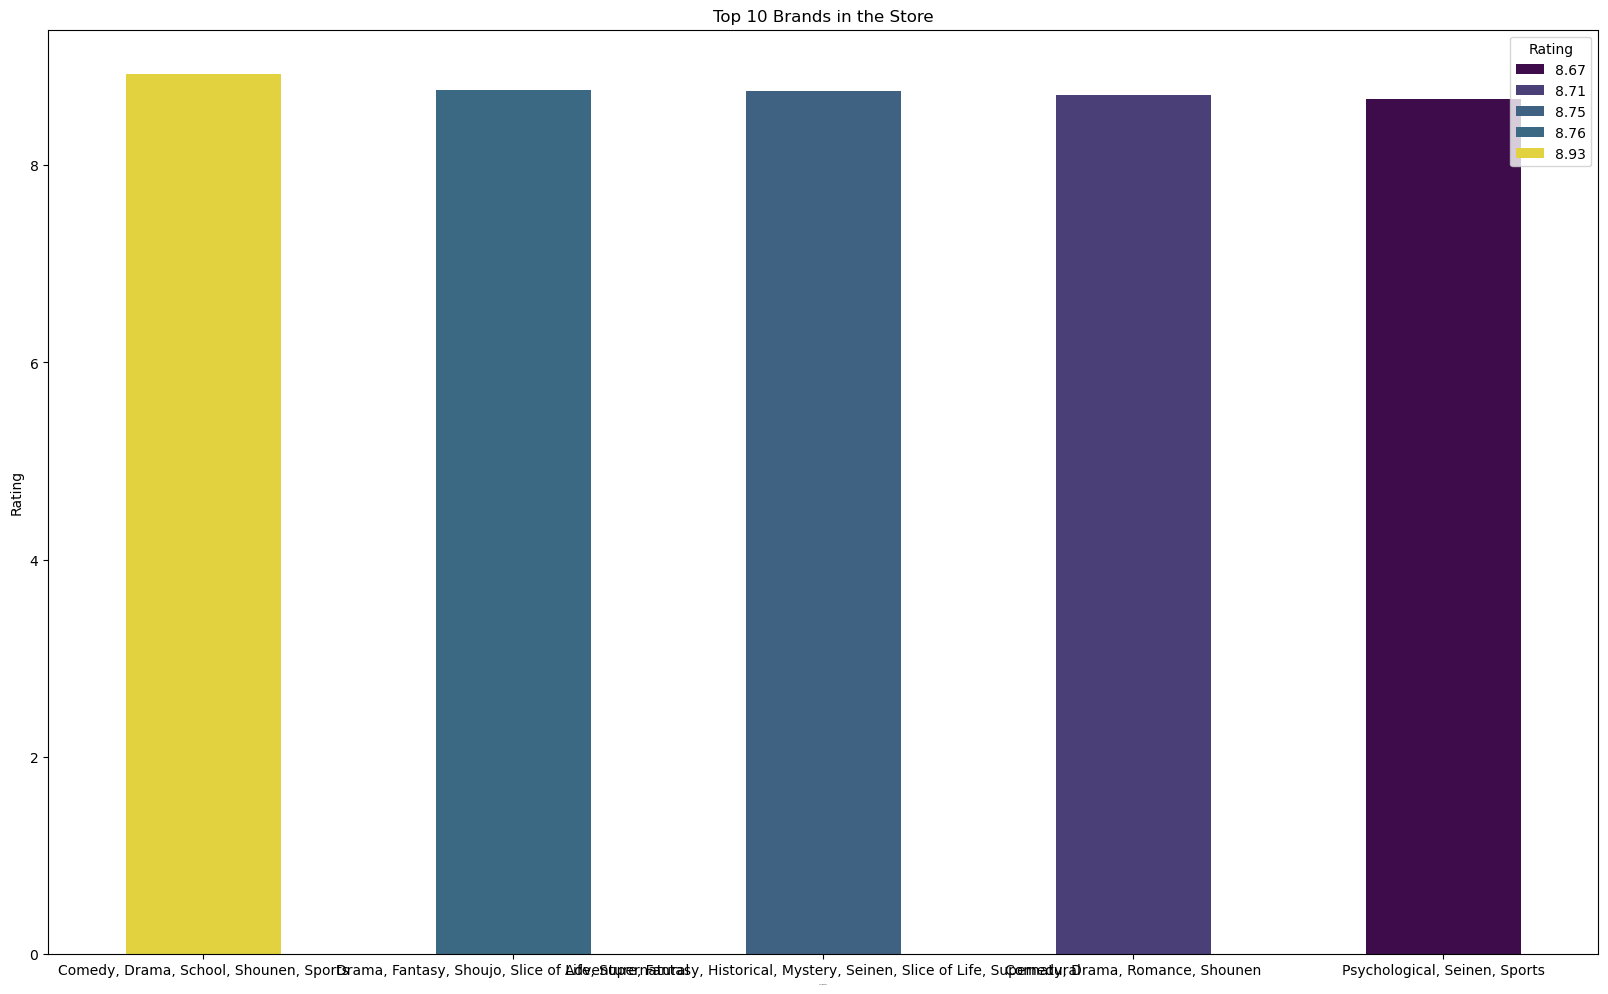

In [44]:
#Plotting
plt.figure(figsize=(20,12))
sns.barplot(x='Genre', y='Rating', data=top_genres, hue='Rating', palette='viridis', width=0.5)
plt.title('Top 10 Brands in the Store')
plt.xlabel('Top Genres', fontsize=1)
plt.ylabel('Rating')
plt.show()

## Data cleaning and tags creation

In [47]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [49]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\himak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\himak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Genre column processsing

In [52]:
train_data['Genre'] = train_data['Genre'].str.replace(',','')

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\2916891629.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Genre'] = train_data['Genre'].str.replace(',','')


In [54]:
train_data

,UserID,AnimeID,Name,Genre,Type,EpisodeCount,Rating,ImageURL,time_of_day,purchase_history
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,https://haruhichan.com/wp-content/uploads/Pers...,Morning,3
1,214,3358,Kure-nai,Comedy Drama Martial Arts,TV,12,7.52,https://cdn.statically.io/img/nimegami.id/f=au...,Evening,5
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,Comedy Slice of Life,TV,12,4.92,https://store.donanimhaber.com/36/59/7b/36597b...,Evening,0
3,7,9239,Scoopers,Action Sci-Fi,OVA,1,6.08,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,Morning,5
4,220,9204,Omae Umasou da na,Action Adventure Fantasy Kids,Movie,1,8.13,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,Morning,4
...,...,...,...,...,...,...,...,...,...,...
995,499,10445,Perfect Day,Music,Music,1,7.59,https://vignette3.wikia.nocookie.net/tokyoghou...,Afternoon,4
996,74,1264,Yoroiden Samurai Troopers,Adventure Samurai Sci-Fi Shounen,TV,39,7.21,https://images-na.ssl-images-amazon.com/images...,Night,4
997,393,3439,Darcrows,Hentai,OVA,2,5.86,https://cdn.myanimelist.net/images/anime/6/589...,Morning,0
998,167,3518,Ginga no Uo Ursa Minor Blue,Fantasy Kids,OVA,1,6.33,https://cdn.myanimelist.net/images/anime/1226/...,Night,4


In [56]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    cleaned_words = [word for word in words if word.isalpha() and word not in stop_words]
    return cleaned_words

In [58]:
def generate_tags(row):
    #Form single string with diffrent columns for processing
    combined_text = f"{row['Name']} {row['Genre']} {row['Type']}"
    cleaned_words = clean_text(combined_text)

    return ', '.join(set(cleaned_words)) #set removes duplicates

train_data['Tags'] = train_data.apply(generate_tags, axis=1)

# for column in ['Name', 'Genre', 'Type']:
#     train_data[column] = train_data[column].apply(clean_text)
#     train_data[column] = train_data[column].apply(lambda tokens: ', '.join(tokens))
    

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\2233040642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Tags'] = train_data.apply(generate_tags, axis=1)


In [60]:
train_data.to_csv('AnimeDataWithTags.csv')

In [62]:
train_data

,UserID,AnimeID,Name,Genre,Type,EpisodeCount,Rating,ImageURL,time_of_day,purchase_history,Tags
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,https://haruhichan.com/wp-content/uploads/Pers...,Morning,3,"music, pupa, yumemiru, dreaming, bokura"
1,214,3358,Kure-nai,Comedy Drama Martial Arts,TV,12,7.52,https://cdn.statically.io/img/nimegami.id/f=au...,Evening,5,"comedy, tv, drama, martial, arts"
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,Comedy Slice of Life,TV,12,4.92,https://store.donanimhaber.com/36/59/7b/36597b...,Evening,0,"life, cocoa, comedy, tv, e, youkoso, color, sl..."
3,7,9239,Scoopers,Action Sci-Fi,OVA,1,6.08,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,Morning,5,"ova, scoopers, action"
4,220,9204,Omae Umasou da na,Action Adventure Fantasy Kids,Movie,1,8.13,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,Morning,4,"na, movie, da, fantasy, action, kids, adventur..."
...,...,...,...,...,...,...,...,...,...,...,...
995,499,10445,Perfect Day,Music,Music,1,7.59,https://vignette3.wikia.nocookie.net/tokyoghou...,Afternoon,4,"day, perfect, music"
996,74,1264,Yoroiden Samurai Troopers,Adventure Samurai Sci-Fi Shounen,TV,39,7.21,https://images-na.ssl-images-amazon.com/images...,Night,4,"tv, shounen, adventure, yoroiden, troopers, sa..."
997,393,3439,Darcrows,Hentai,OVA,2,5.86,https://cdn.myanimelist.net/images/anime/6/589...,Morning,0,"hentai, ova, darcrows"
998,167,3518,Ginga no Uo Ursa Minor Blue,Fantasy Kids,OVA,1,6.33,https://cdn.myanimelist.net/images/anime/1226/...,Night,4,"ginga, fantasy, kids, ursa, ova, blue, uo, minor"


## Rating based recommendation system

In [64]:
##For first Time
rating_ranked_data = train_data.groupby(['Name', 'EpisodeCount', 'Genre', 'ImageURL'])['Rating'].mean().reset_index()

In [66]:
top_rated_items = rating_ranked_data.sort_values(by='Rating', ascending=False)

In [68]:
rating_based_recommendation=top_rated_items.head(10)

In [70]:
rating_based_recommendation['Rating'] = rating_based_recommendation['Rating'].astype(int)
rating_based_recommendation['EpisodeCount'] = rating_based_recommendation['EpisodeCount'].astype(int)

C:\Users\himak\AppData\Local\Temp\ipykernel_20128\3334608908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_based_recommendation['Rating'] = rating_based_recommendation['Rating'].astype(int)
C:\Users\himak\AppData\Local\Temp\ipykernel_20128\3334608908.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_based_recommendation['EpisodeCount'] = rating_based_recommendation['EpisodeCount'].astype(int)


In [72]:
rating_based_recommendation

,Name,EpisodeCount,Genre,ImageURL,Rating
305,Haikyuu!! Second Season,25,Comedy Drama School Shounen Sports,https://cdn.myanimelist.net/images/anime/5/427...,8
306,Haikyuu!! Second Season,25,Comedy Drama School Shounen Sports,https://somoskudasai.com/wp-content/uploads/20...,8
592,Natsume Yuujinchou Go,13,Drama Fantasy Shoujo Slice of Life Supernatural,https://th.bing.com/th/id/OIP.FG71Ttu1NpQMRMl2...,8
576,Mushishi Zoku Shou: Suzu no Shizuku,1,Adventure Fantasy Historical Mystery Seinen Sl...,https://cdn.animenewsnetwork.com/thumbnails/fi...,8
578,Mushishi Zoku Shou: Suzu no Shizuku,1,Adventure Fantasy Historical Mystery Seinen Sl...,https://th.bing.com/th/id/OIP.SuCkSa5yWxHuUXiQ...,8
577,Mushishi Zoku Shou: Suzu no Shizuku,1,Adventure Fantasy Historical Mystery Seinen Sl...,https://store.donanimhaber.com/36/59/7b/36597b...,8
73,Bakuman. 3rd Season,25,Comedy Drama Romance Shounen,https://somoskudasai.com/wp-content/uploads/20...,8
283,Gintama°: Aizome Kaori-hen,2,Comedy Parody,https://upload.wikimedia.org/wikipedia/en/d/dc...,8
659,Ping Pong The Animation,11,Psychological Seinen Sports,https://somoskudasai.com/wp-content/uploads/20...,8
958,Yojouhan Shinwa Taikei,11,Mystery Psychological Romance,https://vignette3.wikia.nocookie.net/tokyoghou...,8


In [74]:
rating_based_recommendation.to_csv('top_animeNew.csv')

## Content based recommendation

In [77]:
#Function

def content_based_recommendations(train_data, item_name, top_n=10):
    #Checking for the name to exist in the dataset
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the dataset.")
        return pd.DataFrame()

    #Create a TF_idf vectorizer for descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    #Apply tf-idf
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    #Calculate cosine similarity
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    #find item index
    item_index = train_data[train_data['Name'] == item_name].index[0]

    #cosine similarity scores
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    #Sort similar items by desc order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    #Get the most similar items except item itself
    top_similar_items = similar_items[1:top_n+1]

    #Get the indices of top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    #Get the details
    recommended_item_details = train_data.iloc[recommended_item_indices][['Name', 'EpisodeCount', 'Genre', 'ImageURL']]

    return recommended_item_details

## Collabarative Filtering

In [80]:
def collborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    #Create the user_item_matrix 
    user_item_matrix=train_data.pivot_table(index='UserID', columns='AnimeID', values='Rating', aggfunc='mean').fillna(0).astype(int)

    #Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    #Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    #Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    #Sort the users by similarity in descending order
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    #Generate recommendation based on similarities
    recommended_items = []

    for user_index in similar_users_indices:
        #Get items rated by the similar users
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index])

        #Extract the item IDs
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    #Get the details of recommended items
    recommended_items_details = train_data[train_data['AnimeID'].isin(recommended_items)][['Name', 'EpisodeCount', 'Genre', 'ImageURL', 'Rating']]

    return recommended_items_details
    

In [82]:
target_user_id = 10
top_n = 5
collaborative_filtering_rec = collborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}")
collaborative_filtering_rec

Top 5 recommendations for User 10


,Name,EpisodeCount,Genre,ImageURL,Rating
0,Dreaming Pupa: Yumemiru Bokura,1,Music,https://haruhichan.com/wp-content/uploads/Pers...,5.20
424,Izakaya no Ichiya,1,Action,https://www.myutaku.com/media/anime/poster/315...,5.31
921,Izakaya no Ichiya,1,Action,https://upload.wikimedia.org/wikipedia/en/d/dc...,5.31


## Hybrid Recommendation system

In [85]:
def hybrid_recommendations(train_data, target_user_id, item_name, top_n=10):
    
    #Content based recommendation
    content_based_rec = content_based_recommendations(train_data, item_name, top_n)

    #Collabarative filtering
    collaborative_filtering_rec = collborative_filtering_recommendations(train_data,target_user_id, top_n)

    #merge above both
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [87]:
target_user_id = 7
item_name = "Kure-nai"
hybrid_rec = hybrid_recommendations(train_data, target_user_id, item_name, top_n=10)
print(f"Hybrid recommendation for the {target_user_id} and {item_name} :")
hybrid_rec

Hybrid recommendation for the 7 and Kure-nai :


,Name,EpisodeCount,Genre,ImageURL,Rating
244,Kure-nai,12,Comedy Drama Martial Arts,https://th.bing.com/th/id/OIP.FtLn5bicY4FF4EIP...,NaN
323,Koihime†Musou,12,Action Adventure Fantasy Historical Martial Arts,https://m.media-amazon.com/images/M/MV5BMGQzYj...,NaN
962,Ranma ½,161,Comedy Fantasy Martial Arts Slice of Life,https://th.bing.com/th/id/OIP.ncXUs8XMlUyH7nKn...,NaN
303,Geori-eui Mubeopja,1,Action Martial Arts,https://upload.wikimedia.org/wikipedia/en/d/dc...,NaN
889,Geori-eui Mubeopja,1,Action Martial Arts,https://th.bing.com/th/id/OIP.nhc5L8tj7VLrMQZT...,NaN
305,Toushinden,2,Action Martial Arts,https://images-na.ssl-images-amazon.com/images...,NaN
205,Dragon Ball,153,Adventure Comedy Fantasy Martial Arts Shounen ...,https://cdn.myanimelist.net/images/anime/6/703...,NaN
972,Kenyuu Densetsu Yaiba,52,Action Comedy Fantasy Martial Arts Shounen,https://upload.wikimedia.org/wikipedia/en/c/c2...,NaN
727,Muteki Kanban Musume,12,Action Comedy Martial Arts Parody Shounen,https://cdn.myanimelist.net/images/anime/3/215...,NaN
263,Sugata Sanshirou,1,Action Martial Arts Sports,https://somoskudasai.com/wp-content/uploads/20...,NaN


In [89]:
train_data

,UserID,AnimeID,Name,Genre,Type,EpisodeCount,Rating,ImageURL,time_of_day,purchase_history,Tags
0,10,32803,Dreaming Pupa: Yumemiru Bokura,Music,Music,1,5.20,https://haruhichan.com/wp-content/uploads/Pers...,Morning,3,"music, pupa, yumemiru, dreaming, bokura"
1,214,3358,Kure-nai,Comedy Drama Martial Arts,TV,12,7.52,https://cdn.statically.io/img/nimegami.id/f=au...,Evening,5,"comedy, tv, drama, martial, arts"
2,477,31139,Ame-iro Cocoa: Rainy Color e Youkoso!,Comedy Slice of Life,TV,12,4.92,https://store.donanimhaber.com/36/59/7b/36597b...,Evening,0,"life, cocoa, comedy, tv, e, youkoso, color, sl..."
3,7,9239,Scoopers,Action Sci-Fi,OVA,1,6.08,https://4.bp.blogspot.com/-zw28qKLRwbU/Wcj2QWE...,Morning,5,"ova, scoopers, action"
4,220,9204,Omae Umasou da na,Action Adventure Fantasy Kids,Movie,1,8.13,https://4.bp.blogspot.com/-NkCyFgISc2o/UEoN8jM...,Morning,4,"na, movie, da, fantasy, action, kids, adventur..."
...,...,...,...,...,...,...,...,...,...,...,...
995,499,10445,Perfect Day,Music,Music,1,7.59,https://vignette3.wikia.nocookie.net/tokyoghou...,Afternoon,4,"day, perfect, music"
996,74,1264,Yoroiden Samurai Troopers,Adventure Samurai Sci-Fi Shounen,TV,39,7.21,https://images-na.ssl-images-amazon.com/images...,Night,4,"tv, shounen, adventure, yoroiden, troopers, sa..."
997,393,3439,Darcrows,Hentai,OVA,2,5.86,https://cdn.myanimelist.net/images/anime/6/589...,Morning,0,"hentai, ova, darcrows"
998,167,3518,Ginga no Uo Ursa Minor Blue,Fantasy Kids,OVA,1,6.33,https://cdn.myanimelist.net/images/anime/1226/...,Night,4,"ginga, fantasy, kids, ursa, ova, blue, uo, minor"


In [91]:
train_data.isnull().sum()

UserID              0
AnimeID             0
Name                0
Genre               0
Type                0
EpisodeCount        0
Rating              0
ImageURL            0
time_of_day         0
purchase_history    0
Tags                0
dtype: int64

## Seasonal recommendations

In [96]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   UserID            992 non-null    int64  
 1   AnimeID           992 non-null    int64  
 2   Name              992 non-null    object 
 3   Genre             992 non-null    object 
 4   Type              992 non-null    object 
 5   EpisodeCount      992 non-null    object 
 6   Rating            992 non-null    float64
 7   ImageURL          992 non-null    object 
 8   time_of_day       992 non-null    object 
 9   purchase_history  992 non-null    int64  
 10  Tags              992 non-null    object 
dtypes: float64(1), int64(3), object(7)
memory usage: 93.0+ KB


In [102]:
label_encoder = LabelEncoder()
train_data['time_of_day'] = label_encoder.fit_transform(train_data['time_of_day'])

In [104]:
train_data['time_of_day'].nunique()

4

In [110]:
def save_top_10_by_time_of_day(df, time_of_day):
    # Filter by time_of_day
    filtered_df = train_data[train_data['time_of_day'] == time_of_day]
    
    # Sort by purchase_history in descending order and take the top 10
    top_10 = filtered_df.nlargest(10, 'purchase_history')
    
    # Save to CSV
    top_10.to_csv(f'TOD{time_of_day}.csv', index=False)

# Loop through the 4 time_of_day values (1, 2, 3, 4)
for time in [1, 2, 3, 4]:
    save_top_10_by_time_of_day(train_data, time)

In [112]:
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(mapping)

{'Afternoon': 0, 'Evening': 1, 'Morning': 2, 'Night': 3}
